# **Heart rate estimation project**
### by Erica Brisigotti, Ekaterina Chueva & Nadillia Saphutra

## 0. **Introduction**
[THIS PART MUST BE CHANGED AND INTEGRATED WITH DETAILS ABOUT HEART RATE AND CYCLE, SCG AND BCG, AND WITH ALL THE THEORETICAL INFO THAT WE'RE USING TO MAKE INFORMED DECISIONS LATER IN THE ANALYSIS PART]

Seismocardiography([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure Heart Rate (HR) and Respiratory Rate (RR) with the detector positioned above sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., accelerometer platform mounted under the slats of the bed).   
  
MuSe(Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provide by [221e](https://www.221e.com). In the context of this project, It allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the heart rate of an healthy subject, given linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform. 
The study must be performed on two datasets: the first is the compulsory one (**center_sternum.txt**) while the second is left at the discretion of the group, among those made available for the assignment.

**N.B: Remember that normal beat is around [40-100] bpm.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import fftpack, stats, signal
from scipy.optimize import curve_fit
import scipy.linalg as la
import pywt

## 1. **Data preparation**

### 1.1 **Selecting columns + accounting for offsets**

Even before uploading the data, it is well-known that there are 16 columns with different meanings. Specifically:
* **Log Freq** stands for the acquisition  in Hz (i.e., sampling interval is constant).
* **AccX, AccY, AccZ** are the measured magnitude of linear acceleration along each axis.
* **GyroX, GyroY, GyroZ** are the measured magnitude of angular velocity along each axis.
* **MagnX, MagnY, MagnZ** are the measured magnitude of magnetic field along each axis.
* **qw, qi, qj, qk** are the quaternion components, representing the spatial orientation of the Muse system.

Further *a priori* information follows from the theoretical information (previously explained in the introduction) about the techniques to be implemented: SCG and BCG. Both of these strategies analyse the evolution in time of accelleration and angular momentum. Therere, only accelerometer, gyrometer and time measurements will be needed.

The other physical quantities can be discarded.

Such statements are supported by the data, which is uploaded (as a Pandas' dataframe) and statistically analyzed through the appropriate Pandas' built-in function (<a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html"> <code>pandas.describe</code> </a>).

In [2]:
file_name = 'center_sternum.txt'
just_uploaded = pd.read_csv(file_name, delimiter='\t')
all_data = pd.DataFrame(just_uploaded)
display(all_data)
all_data.describe()

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
5,5,200,1576222772,947.391,418.277,55.083,32.076340,2.290076,9.328244,-454,-492,-173,0.718660,0.283120,-0.635029,0.010437
6,5,200,1576222772,932.934,424.621,47.397,33.755730,2.381679,13.297710,-454,-492,-173,0.716134,0.285531,-0.636799,0.010529
7,5,200,1576222772,945.134,482.022,62.891,39.480920,8.412213,7.816794,-454,-492,-173,0.713468,0.289682,-0.637929,0.009796
8,5,200,1576222772,916.891,536.556,44.896,45.832060,1.435115,-2.000000,-454,-492,-173,0.711580,0.294961,-0.637654,0.007050
9,5,200,1576222772,992.592,443.958,8.235,43.374050,-3.007634,-6.290076,-455,-493,-170,0.707470,0.299326,-0.640187,0.007202


,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
count,16506.0,16506.0,1.650600e+04,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000
mean,5.0,200.0,1.576223e+09,35.603752,121.754422,-897.001465,-1.885665,3.636535,-0.818354,-231.327881,-432.637405,397.903005,0.063803,0.490530,-0.764329,-0.039947
std,0.0,0.0,2.189258e+01,232.624330,62.077114,215.230574,13.223364,17.399954,10.595643,67.200320,16.526077,123.871453,0.144073,0.197328,0.326346,0.057694
min,5.0,200.0,1.576223e+09,-722.118000,-387.838000,-1731.973000,-359.496200,-213.557300,-126.351100,-511.000000,-559.000000,-178.000000,0.004428,-0.622059,-0.892911,-0.096347
25%,5.0,200.0,1.576223e+09,-35.258000,111.020000,-958.310000,-2.839695,3.206107,-1.175573,-213.000000,-434.000000,427.000000,0.021518,0.493858,-0.859676,-0.060732
50%,5.0,200.0,1.576223e+09,-29.585000,115.900000,-948.733000,-2.137405,3.664122,-0.854962,-212.000000,-432.000000,429.000000,0.024636,0.529649,-0.836619,-0.059511
75%,5.0,200.0,1.576223e+09,-22.692000,120.475000,-937.692000,-1.206107,4.213740,-0.549618,-211.000000,-431.000000,433.000000,0.027304,0.564768,-0.813227,-0.057619
max,5.0,200.0,1.576223e+09,1228.601000,1004.609000,3087.000000,381.160300,349.816800,187.603100,-130.000000,-289.000000,481.000000,0.792622,0.624806,0.921293,0.251900


The brief descriptive statistics provided by the <code>pandas.describe</code> function are particularly helpful in getting the time at which every measurement has been taken.
The **Log Freq** data, which represents the acquisition rate (in Hz), is constant and therefore allows for straigh-forward identification of the time interval between two successive measurements:

This new time notation is adopted to substitute the "Timestamp" column, which is ambiguous because of its repetitive values.

The new notation simply consists of a vector with increasing values of time, representing the instant at which the corresponding measurements are taken.

In [3]:
freq = all_data['Log Freq'].unique()[0] # Hz
time = np.arange(0,(len(all_data.index)/freq),(1/freq)) # seconds

Furthermore, the units of measurement for acceleration (milli-g) and angular velocity (degrees-per-second) are found in the calibration file (**README1.txt**).
    
$$ w[rad/s] = \frac{w[dps]*200}{2^{15}}*\frac{\pi}{180} $$


All unnecessary columns can now be dropped: at the same time, a new column is added to store the new time vector.

In [4]:
data = all_data.drop(['MagnX','MagnY','MagnZ','qw','qi','qj','qk','Log Mode','Log Freq','Timestamp'], axis = 1)
data.insert(0, "Time", time)
data #.describe()

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580
1,0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466
2,0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382
3,0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733
4,0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267
5,0.025,947.391,418.277,55.083,32.076340,2.290076,9.328244
6,0.030,932.934,424.621,47.397,33.755730,2.381679,13.297710
7,0.035,945.134,482.022,62.891,39.480920,8.412213,7.816794
8,0.040,916.891,536.556,44.896,45.832060,1.435115,-2.000000
9,0.045,992.592,443.958,8.235,43.374050,-3.007634,-6.290076


We can now finally use the information given by the calibration (contained in 'README1' for the "center_sternum" file), at least the more obvious ones given by the offset of the accelerometer.

In [5]:
acc_offsets = np.array( [ -3.929942 , -13.7467 , 60.67546 ] )

data['AccX'] += acc_offsets[0]
data['AccY'] += acc_offsets[1]
data['AccZ'] += acc_offsets[2]


data.describe()

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
count,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000
mean,41.262500,31.673810,108.007722,-836.326005,-1.885665,3.636535,-0.818354
std,23.825081,232.624330,62.077114,215.230574,13.223364,17.399954,10.595643
min,0.000000,-726.047942,-401.584700,-1671.297540,-359.496200,-213.557300,-126.351100
25%,20.631250,-39.187942,97.273300,-897.634540,-2.839695,3.206107,-1.175573
50%,41.262500,-33.514942,102.153300,-888.057540,-2.137405,3.664122,-0.854962
75%,61.893750,-26.621942,106.728300,-877.016540,-1.206107,4.213740,-0.549618
max,82.525000,1224.671058,990.862300,3147.675460,381.160300,349.816800,187.603100


### 1.2 **representing the columns + selecting an appropriate time-window**

The selected columns are devided into two groups based on their physical quantity and their evolution in time is represented in a graph.

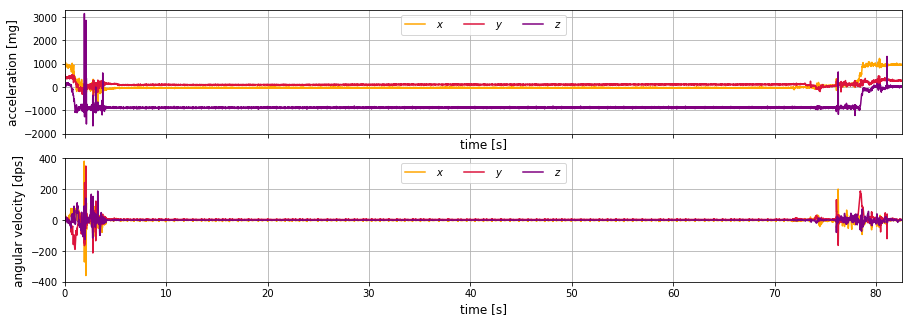

In [6]:
fig1 , ax1 = plt.subplots( nrows = 2 , ncols = 1 , sharex = True , figsize = ( 15 , 5 ))

ax1[0].plot( data['Time'] , data['AccX'] , '-' , label=' $x$ ' , color='orange' )
ax1[0].plot( data['Time'] , data['AccY'] , '-' , label=' $y$ ' , color='crimson' )
ax1[0].plot( data['Time'] , data['AccZ'] , '-' , label=' $z$ ' , color='purple' )
ax1[0].set_xlim( 0 , data['Time'].max() )
ax1[0].set_ylim( -2000 , 3300 )
ax1[0].set_xlabel( 'time [s]' , fontsize = 12 )
ax1[0].set_ylabel( 'acceleration [mg]' , fontsize = 12 )
ax1[0].legend( loc='upper center' , fontsize = 10 , ncol = 3 )
ax1[0].grid()

ax1[1].plot( data['Time'] , data['GyroX'] , '-' , label = ' $x$ ' , color='orange' )
ax1[1].plot( data['Time'] , data['GyroY'] , '-' , label = ' $y$ ' , color='crimson' )
ax1[1].plot( data['Time'] , data['GyroZ'] , '-' , label = ' $z$ ' , color='purple' )
ax1[1].set_xlim( 0 , data['Time'].max() )
ax1[1].set_ylim( -400 , 400 )
ax1[1].set_xlabel( 'time [s]' , fontsize = 12 )
ax1[1].set_ylabel( 'angular velocity [dps]' , fontsize = 12 )
ax1[1].legend( loc='upper center' , fontsize = 10  , ncol = 3 )
ax1[1].grid()


A few observations come up from a graphical representation of the remaining data:
- all columns follow a similar trend, which consists of small obscillations around an offset for the majority of time and some larger fluctuations at the beginning and end of each column
- if the larger fluctuations were caused by the heartbeat, the patient's heart wouldn't beat for over a minute (would be dead) which is paradoxical: it follows that the interesting, heart-rate related information is be contained in the innermost, small obscillating portion of each set of measurement
- the larger fluctuations at the beginning and at the end of each measurement set are therefore regarded as anomalies (i.e. to be discarded), possibly due to the patient positioning himself or the devices being set up for the measurements

A more quantitative approach to the selection of the data is based on the standard deviation for each column.
The algorithm starts from the center of the dataset, takes increasingly wider subsets of each column and calculates the corresponding standard deviation.
    
To allow for a more intuitive graphical representation, this algorythm depends only on one variable: in ordert to do that, each interval starts or ends at the center of the vector. Consequently, their shape is either

$$[a,\tfrac{1}{2}l] \wedge a<\tfrac{1}{2}l$ \;\; \text{or} \;\; $[\tfrac{1}{2}l,b] \wedge b>\tfrac{1}{2}l$$

where $l$ is the length of the vector.

The selection of an appropriate time window is then made based on the evolution of standard deviation.

In [7]:
def std_from_center( vect ):
    vect = np.array( vect )
    center_idx = int( vect.shape[0]/2 )
    std_down = [ np.std(vect[ (center_idx-idx):center_idx ] ) for idx in range(1,center_idx,1) ] 
    std_up = [ np.std( vect[ center_idx:(center_idx+idx) ] ) for idx in range(1,center_idx,1) ] 
    return np.concatenate((std_down[::-1],std_up))

8253
the percentage of measurements to keep is  78.75923906458257
8.255 70.145


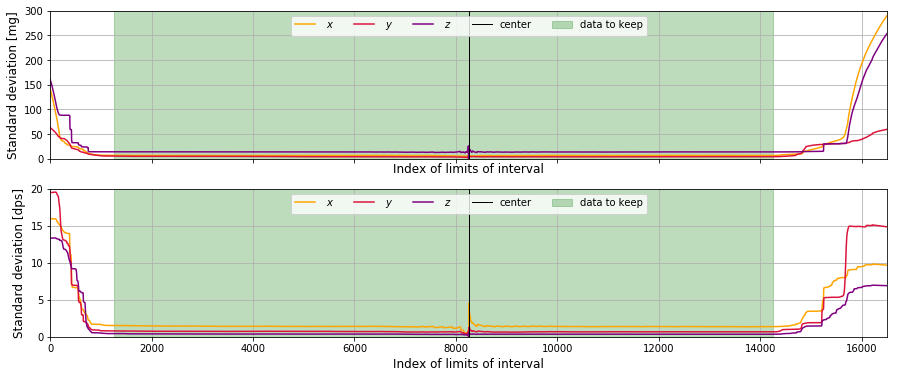

In [8]:
fig2,ax2 = plt.subplots( nrows = 2 , ncols = 1 , sharex = True , figsize = ( 15 , 6 ) )
center_idx = int( data.shape[0]/2 )
down_cut = 7000
up_cut = 6000
print( center_idx )
print('the percentage of measurements to keep is ', (down_cut+up_cut)/data.shape[0]*100)
down_idx = center_idx-down_cut
up_idx = center_idx+up_cut
down_limit = ( data['Time'] )[1651]  #[ down_idx ]
up_limit = ( data['Time'] )[14029]  #[ up_idx ]
print(down_limit,up_limit)

ax2[0].plot( std_from_center( data['AccX']) , '-' , label = ' $x$ ' , color='orange' )
ax2[0].plot( std_from_center( data['AccY']) , '-' , label = ' $y$ ' , color='crimson' )
ax2[0].plot( std_from_center( data['AccZ']) , '-' , label = ' $z$ ' , color='purple' )
ax2[0].axvline( x = center_idx , linestyle = '-' , color = 'k' , label = 'center' , linewidth = 1 )
ax2[0].fill_betweenx( y = [0,300] , x1 = down_idx , x2 = up_idx , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax2[0].set_xlim( 0 , data.shape[0] )
ax2[0].set_ylim( 0 , 300 )
ax2[0].set_xlabel( 'Index of limits of interval' , fontsize = 12 )
ax2[0].set_ylabel( 'Standard deviation [mg]' , fontsize = 12 )
ax2[0].legend( loc = 'upper center' , ncol = 5 , fontsize = 10 )
ax2[0].grid()

ax2[1].plot( std_from_center( data['GyroX']) , '-' , label = ' $x$ ' , color='orange' )
ax2[1].plot( std_from_center( data['GyroY']) , '-' , label = ' $y$ ' , color='crimson' )
ax2[1].plot( std_from_center( data['GyroZ']) , '-' , label = ' $z$ ' , color='purple' )
ax2[1].axvline( x = center_idx , linestyle = '-' , color = 'k' , label = 'center' , linewidth = 1 )
ax2[1].fill_betweenx( y = [0,20] , x1 = down_idx, x2 = up_idx , color='forestgreen' , alpha = 0.3 , label='data to keep' )
ax2[1].set_xlim( 0 , data.shape[0] )
ax2[1].set_ylim( 0 , 20 )
ax2[1].set_xlabel( 'Index of limits of interval' , fontsize = 12 )
ax2[1].set_ylabel( 'Standard deviation [dps]' , fontsize = 12 )
ax2[1].legend( loc = 'upper center' , ncol = 5 , fontsize = 10 )
ax2[1].grid()

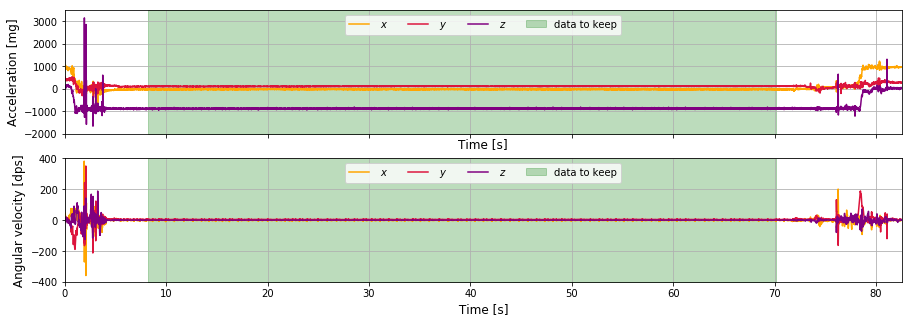

In [9]:
fig3, ax3 = plt.subplots( nrows = 2 , ncols = 1 , sharex = True , figsize = ( 15 , 5 ) )

ax3[0].plot( data['Time'] , data['AccX'] , '-' , label = ' $x$ ' , color = 'orange' )
ax3[0].plot( data['Time'] , data['AccY'] , '-' , label = ' $y$ ' , color = 'crimson' )
ax3[0].plot( data['Time'] , data['AccZ'] , '-' , label = ' $z$ ' , color = 'purple' )
ax3[0].fill_betweenx( y = [-2000,+3500] , x1 = down_limit , x2 = up_limit , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax3[0].set_xlim( min(data['Time']) , max(data['Time']) )
ax3[0].set_ylim( -2000 , +3500 )
ax3[0].set_xlabel( 'Time [s]' , fontsize = 12 )
ax3[0].set_ylabel( 'Acceleration [mg]' , fontsize = 12 )
ax3[0].legend( loc = 'upper center' , ncol = 4 , fontsize = 10 )
ax3[0].grid()

ax3[1].plot( data['Time'] , data['GyroX'] , '-' , label = ' $x$ ' , color='orange' )
ax3[1].plot( data['Time'] , data['GyroY'] , '-' , label = ' $y$ ' , color='crimson' )
ax3[1].plot( data['Time'] , data['GyroZ'] , '-' , label = ' $z$ ' , color='purple' )
ax3[1].fill_betweenx( y=[ -400 , +400 ] , x1=down_limit , x2 = up_limit , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax3[1].set_xlim( min( data['Time'] ) , max( data['Time'] ) )
ax3[1].set_ylim( -400, +400 )
ax3[1].set_xlabel( ' Time [s] ' , fontsize=12 )
ax3[1].set_ylabel( ' Angular velocity [dps] ' , fontsize=12 )
ax3[1].legend( loc = 'upper center' , ncol = 4 , fontsize = 10 )
ax3[1].grid()

The choice of time-window is proven to be right by a simple representation of the columns. The data corresponding to the outside of such window is dropped and the indexes of are adjusted to compensate for the cut.

In [10]:
ok_data = data.copy()
ok_data.drop( data[ data['Time'] <= down_limit ].index, inplace=True)
ok_data.drop( data[ data['Time'] >= up_limit ].index, inplace=True)
ok_data.set_index( np.arange(len(ok_data) ),inplace=True)

### 1.3 **PCA + choosing an appropriate combination of columns**

Before going further into the analysis, it's safe to question weather all the selected columns are actually necessary to the description of the system. Two key factors must included in this process:
    - firstly, one or more of the columns could contain redundant information or small variations compared to the others: to identify both instances, a Principal Component Analysis is implemented: it returns the percentages of variation corresponding to each column, based on which we're able to deduct the ones to keep.
    - if more than one column is to be kept, a useful way to simplify the analysis consists of taking a combination of such columns. The choice of combination usually naturally follows from the symmetry of the system

These two steps were executed in parallel based on the physical quantity they represent.
    
Lastly, a further semplification of the future analysis follows from similar examples in literature (ref): the two physical quantities can be normalized and summed together.

In [11]:
def PCA_pairplot( vect ):
    # sns.pairplot( vect , height = 2)
    vect_cov = np.cov( vect.T )
    vect_val , vect_vect = la.eig( vect_cov )
    vect_val = np.real_if_close( vect_val )
    perc = vect_val*100/vect_val.sum()
    return perc

#### 1.3.1 **PCA on acceleration**

In [12]:
print( 'the percentages corresponding the components of the acceleration are ' , PCA_pairplot( ok_data[ ['AccX','AccY','AccZ'] ] ) )

the percentages corresponding the components of the acceleration are  [76.78593524 13.95437957  9.25968519]


#### 1.3.2 **PCA on angular velocity**

In [13]:
print( 'the percentages corresponding the components of the angular velocity are ' , PCA_pairplot( ok_data[ ['GyroX','GyroY','GyroZ'] ] ) )

the percentages corresponding the components of the angular velocity are  [80.64443936 15.77245657  3.58310407]


#### 1.3.3 **Combining columns**

None of the columns can be discarded since all the corresponding percentages are non-negligible. On the other hand, they can be combined into a single variable to smoothen future analysis. 

The simplest approach consists of switching from a Carthesian to a polar set of coordinates

$$ \vec{v} \rightarrow \left(\,  x \, , \, y \, , \, z \, \right) \rightarrow \left(\,  \| \vec{v} \| \, , \, \theta \, , \, \phi \, \right) \;\;\; \text{where} \;\;\; \| \vec{v} \| = \sqrt{x^2 + y^2 + z^2} $$

and then taking just the norm $\| \vec{v} \|$ of the physical quantity $\vec{v}$. 

There is no need to switch to the eigenvector basis (from PCA) before calculating the norm $\| \vec{v} \|$ since it is invariant under rotations of the plane around the origin.

In [14]:
acc_norm = np.array( np.sqrt( ok_data['AccX']**2 + ok_data['AccY']**2 + ok_data['AccZ']**2 ))
gyro_norm = np.array( np.sqrt( ok_data['GyroX']**2 + ok_data['GyroY']**2 + ok_data['GyroZ']**2 ))

At the same time, the normalized norms of these phisical quantities can be summed together, as seen in many examples in literature. This combination is justified by the fact that the waves are in phase.

In [15]:
time = np.array( ok_data['Time'] )
norm = acc_norm/np.linalg.norm(acc_norm) + gyro_norm/np.linalg.norm(gyro_norm)
to_analyze = pd.DataFrame( { 'Time' : time , 'Norm' : norm })

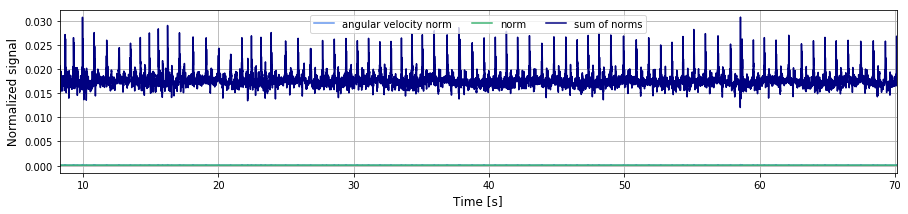

In [16]:
fig4, ax4 = plt.subplots( nrows = 1 , ncols = 1 , sharex = True , figsize = ( 15 , 3 ) )

ax4.plot( ok_data['Time'] , gyro_norm /gyro_norm.sum(), '-' , label = 'angular velocity norm' , color = 'cornflowerblue' )
ax4.plot( ok_data['Time'] , acc_norm/acc_norm.sum() , '-' , label = 'norm' , color = 'mediumseagreen' )
ax4.plot( time , norm , '-' , label = 'sum of norms' , color = 'navy' )
ax4.set_xlim( min( time ) , max( time ) )
ax4.set_xlabel( 'Time [s]' , fontsize = 12 )
ax4.set_ylabel( ' Normalized signal ' , fontsize = 12 )
ax4.legend( loc = 'upper center' , ncol = 3 , fontsize = 10 )
ax4.grid()


### 1.4. **Statistical analysis**

A statistical description of the combined dataset is another good measure that can implemented before the analysis.

In [17]:
std_description = pd.concat( [ to_analyze.describe() , pd.DataFrame( to_analyze.median() , columns=['median'] ).transpose() , 
                                pd.DataFrame( to_analyze.var(), columns=['variance'] ) .transpose() ] )
print(' the median to std ratio is ', np.round(std_description['Norm']['median']/std_description['Norm']['std']),':1') 
std_description

 the median to std ratio is  11.0 :1


,Time,Norm
count,12377.000000,12377.000000
mean,39.200000,0.017820
std,17.865382,0.001656
min,8.260000,0.012026
25%,23.730000,0.016935
50%,39.200000,0.017522
75%,54.670000,0.018214
max,70.140000,0.030754
median,39.200000,0.017522
variance,319.171888,0.000003


In [18]:
to_analyze.corr()

,Time,Norm
Time,1.000000,-0.063993
Norm,-0.063993,1.000000


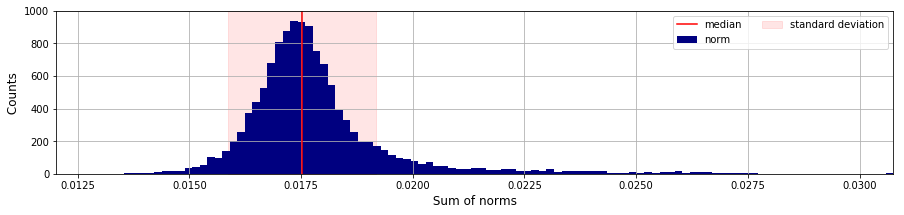

In [19]:
fig5, ax5 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 3 ) )
ax5.hist( norm , bins = int( np.sqrt( len(norm) ) ) , label = 'norm' , color = 'navy' )
ax5.axvline( x = std_description['Norm']['median'] , linestyle = '-' , color = 'r' , label = 'median' )
ax5.fill_betweenx( y=[ 0 , 1000 ] , x1 = (std_description['Norm']['median']-std_description['Norm']['std']) , 
                   x2 = (std_description['Norm']['median']+std_description['Norm']['std']) , 
                   color = 'red' , alpha = 0.1 , label = 'standard deviation' )
ax5.set_xlim( min( norm ) , max( norm ) )
ax5.set_ylim( 0 , +1000 )
ax5.set_xlabel( ' Sum of norms ' , fontsize = 12 )
ax5.set_ylabel( ' Counts ' , fontsize = 12 )
ax5.legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax5.grid()
plt.show()

A few observations follow from the statistical descriptors and histogras:
- the distribution is slightly asymmetric, as shown by the difference between the mean and median of <code>Norm</code>
- the distribution already shows a clear peak centered in the median since the median-to-std ratio for <code>Norm</code> is 11:1.

## 2. **Heart-rate estimation through FFT**

The first strategies implemented consists of a Fast Fourier Transform algorythm. The algorythm computes the discrete Fourier transform of the signal (in section 2.1), particularly its power. A desired frequency can be identified as the one of the local maxima of the power.

A band-pass filter is then applied to the fft transform (in section 2.2) to select the desired local maxima based on the range of theoretically possible heart-rates (40-100 bpm). Together with the Inverse Fast Fourier Transform, it can be used as method to get a clearer signal, independently of heart-rate identification,


### 2.1 **FFT +  power plot**

In [20]:
def power_fft( vect , timestamp ):
    # The FFT of the signal Z around the area of heart beat frequencies
    vect_fft = fftpack.fft( vect )
    # And the power (sig_fft is of complex dtype)
    vect_power = np.abs( vect_fft )
    # The corresponding frequencies
    vect_all_freq = fftpack.fftfreq( vect.size, d = timestep )
    return vect_fft , vect_power , vect_all_freq

timestep = 1/freq
norm_fft , norm_power , norm_all_freq = power_fft( np.asarray(to_analyze['Norm']) , timestep )

In [21]:
down_freq_lim = 40/60 # Hz
up_freq_lim = 100/60 # Hz

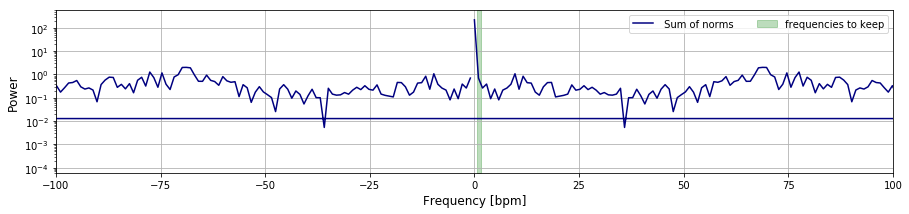

In [22]:
fig6 , ax6 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 3 ) )
ax6.plot( norm_all_freq*60 , norm_power , '-' , label = ' Sum of norms ' , color = 'navy' )
ax6.fill_betweenx( y=[ 10**(-6)*60 , 10**1*60 ], x1 = down_freq_lim , x2 = up_freq_lim , color = 'forestgreen' , alpha = 0.3 , label = 'frequencies to keep' )
ax6.set_xlim( min( norm_all_freq ) , max( norm_all_freq ) )
ax6.set_ylim( 10**(-6)*60 , 10**1*60 )
ax6.set_xlabel( 'Frequency [bpm]' , fontsize = 12 )
ax6.set_ylabel( 'Power' , fontsize = 12 )
ax6.set_yscale( 'log' )
ax6.legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax6.grid()
plt.show()

<font color='red'> The spectrum in output to the direct FFT is symmetric with respect to the origin and includes a wide range of frequencies. As highlighted in the graphical representation above, only a small section of the spectrum can correspond to the heart-rate (which, at rest, is usually between 40-100 bpm). 
</font>

### 2.2 **Band-pass filter + heart-rate estimation via FFT**

The 40-100 bpm range of possible heart-rate is then used to design a filter to explude the irrelevant frequencies. By selecting this range of frequencies, we're able to identify the desired local maxima that will constitute the heart rate, and to estimate its error.

In [23]:
def band_pass_filter( vect_all_freq , vect_power, down_freq_lim , up_freq_lim ):
    vect_mask = np.where( ( down_freq_lim <= vect_all_freq ) & ( vect_all_freq <= up_freq_lim ) )
    vect_freq = vect_all_freq [ vect_mask ]
    vect_peak_freq = vect_freq [ vect_power [ vect_mask ].argmax() ]
    vect_err_peak_freq = ( vect_freq [ (vect_power [ vect_mask ]).argmax() + 1 ] - vect_freq [ (vect_power [ vect_mask ]).argmax() - 1 ] ) / 2
    return vect_mask , vect_freq , vect_peak_freq , vect_err_peak_freq

norm_mask , norm_freq , fft_peak_freq , fft_err_peak_freq = band_pass_filter( norm_all_freq , norm_power , down_freq_lim , up_freq_lim )

print('the peak frequency estimated from the sum of norms is ', fft_peak_freq*60 ,' ± ',fft_err_peak_freq*60 ,' bpm')

the peak frequency estimated from the sum of norms is  68.8373596186475  ±  0.9695402763189764  bpm


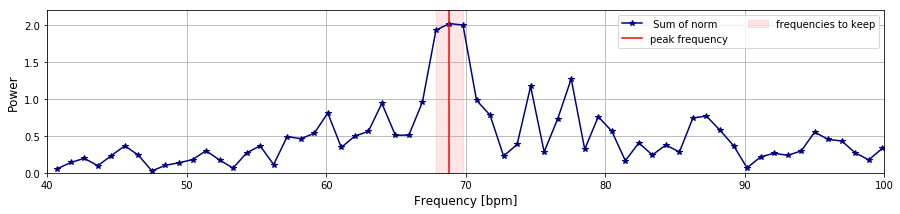

In [40]:
fig7, ax7 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 3 ) )
ax7.plot( norm_freq*60 , norm_power[norm_mask] , '-*' , label = ' Sum of norm' , color = 'navy' )
ax7.axvline( fft_peak_freq*60 , color='red' , label = 'peak frequency')
ax7.fill_betweenx( y=[ 0 , 2.2 ] , x1 = (fft_peak_freq-fft_err_peak_freq)*60 , 
                   x2 = (fft_peak_freq+fft_err_peak_freq)*60 , 
                   color = 'red' , alpha = 0.1 , label = 'frequencies to keep' )
ax7.set_xlim( down_freq_lim*60 , up_freq_lim*60 )
ax7.set_ylim( 0 , 2.2 )
ax7.set_xlabel( 'Frequency [bpm]' , fontsize = 12 )
ax7.set_ylabel( 'Power' , fontsize = 12 )
ax7.legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax7.grid()
plt.show()

### 2.3 **Filtering signal with FFT**

The Inverse Fourier Transform is then applied to the specific range of frequencies selected in the previous section. The output signal to this procedure is clearer and smoother compare to the original signal (in input to the direct Fourier Transform).

In [25]:
def filtered_power( vect_fft , vect_all_freq , down_freq_lim , up_freq_lim ):
    vect_filtered_fft = vect_fft.copy()
    vect_filtered_fft[ np.abs(vect_all_freq) >= up_freq_lim ] = 0
    vect_filtered_fft[ np.abs(vect_all_freq) <= down_freq_lim ] = 0
    vect_filtered = ( fftpack.ifft( vect_filtered_fft ) ).real
    return vect_filtered

norm_filtered = filtered_power( norm_fft , norm_all_freq , down_freq_lim , up_freq_lim )

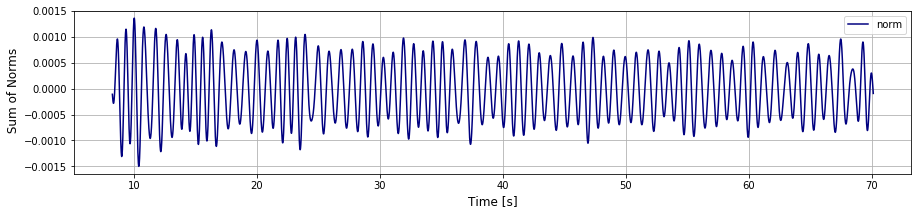

In [26]:
fig8 , ax8 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 3 ) )
ax8.plot(to_analyze['Time'] , norm_filtered , '-' , label = 'norm' , color = 'navy' )
#ax8.set_xlim( 0 , len( norm_filtered_power ) )
#ax8.set_ylim( -5*10**(-5) , +5*10**(-5) )
ax8.set_xlabel( 'Time [s]' , fontsize = 12 )
ax8.set_ylabel( ' Sum of Norms' , fontsize = 12 )
ax8.legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax8.grid()
plt.show()

## 3. **Heart-rate estimation through Wavelet transform**

In this section, the band-pass filtered signal will be processed further with wavelet transform. 

Wavelet transform is a tool to deconstruct signal into its corresponding frequency components along with the time evolution. The temporal information given by this method is an advantage over FFT transformation, and allows for the estimation of Heart-Rate Variability.

Wavelet transform can be divided into two main categories based on the wavelets: discrete wavelet transforms and continous wavelet transforms. 

### 3.1 **Discrete Wavelet Transform**

The reverse biorthogonal 3.9 (rbio3.9) wavelet is chosen to decompose the band-pass filtered signal. 

As seen in the <a href="https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html"> <code>pywt.wavelet</code></a> documentation, the discrete wavelet takes other inputs such as the level of deconstruction, which was set to <code>level=6</code> aftet some tuning. Afterwards, the coefficients corresponding to levels < <code>level=6</code> were discarded by setting them to 0.


In [27]:
def dwt(time, vect, level):
    i = level+1
    coef = pywt.wavedec(vect , 'rbio3.9', level=i )

    for k in range (i):
        if (k != 1)&(k != 2): 
            coef[k] = np.zeros(coef[k].shape)
    dwt_sig = pywt.waverec( coef, 'rbio3.9' )
    fig9 , ax9 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 3 ) )
    ax9.plot(time, dwt_sig[:-1]) #blocked the time frame to see the wave better
    #ax9.set_xlim(37,40)
    ax9.set_xlabel ("Time")
    ax9.set_ylabel ("Magnitude Freq ") #not sure this is the right name for the y axis
    plt.show
    return dwt_sig

/opt/ubuntu-16.04/conda/lib/python3.6/site-packages/pywt/_multilevel.py:148: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a = a[[slice(s) for s in d.shape]]


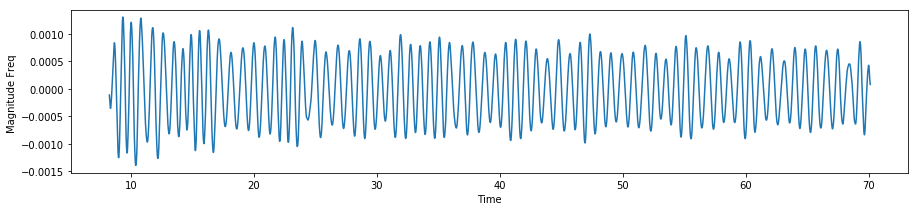

In [28]:
# function dwt(signal, level)
dwt_sig = dwt( time, norm_filtered , 6)

In [29]:
def peaks(time, vect):
    peaks, _ = signal.find_peaks(vect, width = 50) 
#     count BPM
    num_peak = len(peaks)
    time  = time.max() - time.min()
    bps = num_peak/time 
    print('BPM is', bps*60)#times 60 for bpm
#     plot peaks
    plt.figure( figsize = ( 15 , 3 ) )
    plt.plot(vect)
    plt.plot(peaks, vect[peaks], "x")
    #plt.plot(np.zeros_like(x), "--", color="gray")
    plt.show()
    return (peaks)


BPM is 69.81254040077569


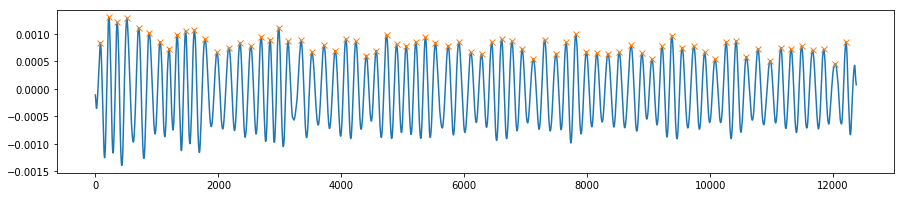

In [30]:
peak = peaks( to_analyze['Time'], dwt_sig)

In [31]:
# histogram functions
def histograms(time, peak):
    fig,ax = plt.subplots(ncols = 2, figsize = ( 15 , 5 ) )
#     HRV Histogram
    times = np.asarray(time)
    hrv = np.zeros(len(peak)-1)
    for i in range (len(hrv)):
        hrv[i] = times[peak[i+1]] - times[peak[i]] 
    value_hrv, bins_hrv, _  = ax[0].hist(hrv,bins='auto', density = True,  stacked = True,  color ='lightblue', ec = 'navy')
    ax[0].set_xlabel ("HRV (second)")  
    
# histogram of BPM
    value_heart, bins_heart, _ = ax[1].hist(1/hrv*60,bins='auto', density = True, stacked = True, color ='lightblue', ec = 'navy')
    ax[1].set_xlabel ("HBM")
    return hrv, value_hrv, bins_hrv, value_heart, bins_heart

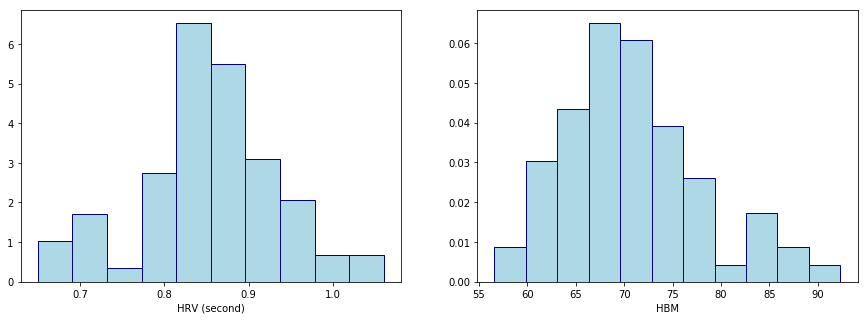

In [32]:
hrv, value_hrv, bins_hrv, value_heart, bins_heart = histograms(to_analyze['Time'], peak)

Gaussian
[6.13036765 0.85771879 0.05717652]
[[ 5.50748991e-01 -1.99178722e-08 -3.42480439e-03]
 [-1.99178722e-08  6.38837223e-05  4.03418351e-10]
 [-3.42480439e-03  4.03418351e-10  6.38881455e-05]]
Cauchy
[1.15561083 0.85329345 0.05335222]
[[ 1.39284094e-02 -1.08326947e-05  7.06444323e-04]
 [-1.08326947e-05  2.47574269e-05 -1.29127660e-06]
 [ 7.06444323e-04 -1.29127660e-06  6.63804925e-05]]


(0.6, 1.1)

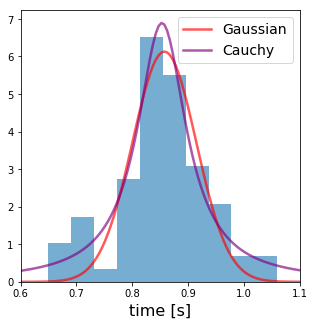

In [33]:
#I want to try to fit with Gaussian, Cauchy, Double exponenetial

def Gauss(x,A,mu,sigma):
    return A*np.exp(-(x - mu)**2/(2 * sigma**2)) 

def Cauchy(x,A,t,s):
    return A/(s*np.pi*(1 + ((x-t)/s)**2 )) 

# def Double_exp(x,A,mu,b,B):
#     return A*np.exp(-np.abs( (x-mu)/b ))/(2*b) + B

##hrv part
bins_mean_hrv=(bins_hrv[:-1]+bins_hrv[1:])/2  
#print(bins_mean_hrv)
#print(value_hrv)

opt_gauss, cov_gauss = curve_fit(Gauss, xdata=bins_mean_hrv, ydata=value_hrv, p0=[16, 0.85, 0.1])
print('Gaussian')
print(opt_gauss)
print(cov_gauss)


opt_cauchy, cov_cauchy = curve_fit(Cauchy, xdata=bins_mean_hrv, ydata=value_hrv, p0=[16, 0.85, 0.1])
print('Cauchy')
print(opt_cauchy)
print(cov_cauchy)

# opt_dexp, cov_dexp = curve_fit(Double_exp, xdata=bins_mean_hrv, ydata=value_hrv, p0=[16, 0.85, 0.1, 2])
# print('Double exponential')
# print(opt_dexp)
# print(cov_dexp)


xspace = np.linspace(0.6,1.1,100)
plt.figure( figsize = ( 5 , 5 ))
plt.hist(hrv, bins='auto', alpha=0.6, density = True, stacked = True)
plt.plot(xspace, Gauss(xspace, *opt_gauss), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
plt.plot(xspace, Cauchy(xspace, *opt_cauchy), color='purple', linewidth=2.5, label='Cauchy', alpha=0.65)
# plt.plot(xspace, Double_exp(xspace, *opt_dexp), color='green', linewidth=2.5, label='Double exponential', alpha=0.65)
plt.legend(loc='best', fontsize=14)
plt.xlabel('time [s]', fontsize=16)
plt.xlim(0.6,1.1)

[58.22667898 61.47248977 64.71830057 67.96411136 71.20992215 74.45573295
 77.70154374 80.94735453 84.19316533 87.43897612 90.68478691]
Gaussian
[5.73618198e-02 6.91859442e+01 5.04020571e+00 7.82301316e-03]
[0.00480028 0.42351388 0.55923804 0.00314474]
Log
[8.11665112e-01 6.93476646e+01 2.06190575e+01 5.65850863e-03]
[0.1312686  0.43424301 2.78329342 0.00382658]


(56, 90)

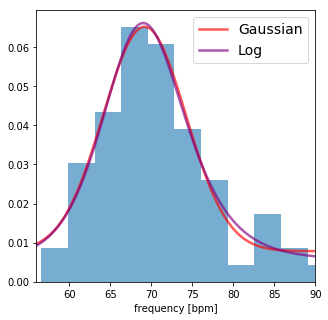

In [34]:
import scipy as sp
import scipy.stats as stats



def Gamma(x,A,mu,b):
    g = 4
    return ((x-mu)/b)**(g-1)*np.exp(-(x-mu)/b)*A/(b*sp.special.gamma(g))


def Log_Logistics(x,A,a,b,B):
    return A*(b/a)*(x/a)**(b-1)/(1 + (x/a)**b)**2 + B

def Gauss2(x,A,mu,sigma,B):
    return A*np.exp(-(x - mu)**2/(2 * sigma**2))+B 

bins_mean_heart=(bins_heart[:-1]+bins_heart[1:])/2
print(bins_mean_heart)

opt_gauss, cov_gauss = curve_fit(Gauss2, xdata=bins_mean_heart, ydata=value_heart, p0=[0.1, 70, 10, 0.2])
print('Gaussian')
print(opt_gauss)
print(np.sqrt(np.diag(cov_gauss)))

#opt_invgauss, cov_invgauss = curve_fit(Inverse_Gauss, xdata=bins_mean_heart, ydata=value_heart, p0=[0.1, 70])
#print('Inverse Gauss')
#print(opt_invgauss)
#print(cov_invgauss)

#opt_gamma, cov_gamma = curve_fit(Gamma, xdata=bins_mean_heart, ydata=value_heart, p0=[2, 40, 5])
#print('Gamma')
#print(opt_gamma)
#print(cov_gamma)


opt_log, cov_log = curve_fit(Log_Logistics, xdata=bins_mean_heart, ydata=value_heart, p0=[1, 70, 20,0.1])
print('Log')
print(opt_log)
print(np.sqrt(np.diag(cov_log)))


xspace = np.linspace(56,90,100)
plt.figure( figsize = ( 5 , 5 ) )
plt.hist((1/hrv)*60, bins='auto', alpha=0.6, density=True)
plt.plot(xspace, Gauss2(xspace, *opt_gauss), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
plt.plot(xspace, Log_Logistics(xspace, *opt_log), color='purple', linewidth=2.5, label='Log', alpha=0.65)
#plt.plot(xspace, Gamma(xspace, *opt_gamma), color='green', linewidth=2.5, label='Gamma', alpha=0.65)
plt.legend(loc='best', fontsize=14)
plt.xlabel('frequency [bpm]')
plt.xlim(56,90)

### 3.2 **Continuous Wavelet Transform**

An alternative strategy for peak identification is given by the Continuous Wavlet transform, which has been implemented through the
<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html"> <code>cwt_find_peaks</code> </a> Scipy function.

This time, the main 



## 4. Respiratory rate estimation through FFT

The respiratory rate can be estimated through a similar strategy to the one presented in section 2.

The FFT-based algorythm selects a range of frequencies corresponding to the possible values of respiratory rate (12-25 breaths per minute). Then the respiratory rate is estimated as the local maxima, together with its error. 

In [35]:
breath_down_freq_lim = 12/60
breath_up_freq_lim = 25/60

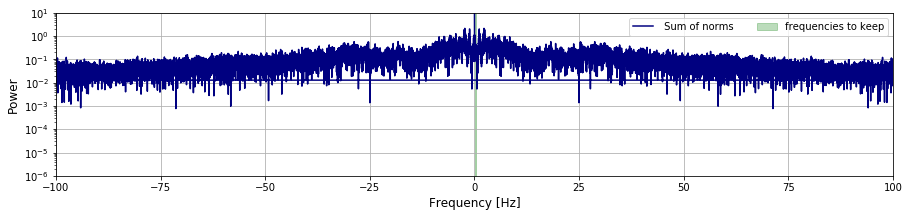

In [36]:
figb1 , axb1 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 3 ) )
axb1.plot( norm_all_freq , norm_power , '-' , label = ' Sum of norms ' , color = 'navy' )
axb1.fill_betweenx( y=[ 10**(-6) , 10**1 ] , x1 = breath_down_freq_lim , x2 = breath_up_freq_lim , color = 'forestgreen' , alpha = 0.3 , label = 'frequencies to keep' )
axb1.set_xlim( min( norm_all_freq ) , max( norm_all_freq ) )
axb1.set_ylim( 10**(-6) , 10**1 )
axb1.set_xlabel( 'Frequency [Hz]' , fontsize = 12 )
axb1.set_ylabel( 'Power' , fontsize = 12 )
axb1.set_yscale( 'log' )
axb1.legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
axb1.grid()
plt.show()

In [37]:
# Adjust mask to freq of heart beat (40bpm and  100 bpm) translate it to sec

def breath_band_pass_filter( vect_all_freq , vect_power, breath_down_freq_lim , breath_up_freq_lim ):
    vect_mask = np.where( ( breath_down_freq_lim <= vect_all_freq ) & ( vect_all_freq <= breath_up_freq_lim ) )
    vect_freq = vect_all_freq [ vect_mask ]
    vect_peak_freq = vect_freq [ vect_power [ vect_mask ].argmax() ]
    vect_err_peak_freq = ( vect_freq [ (vect_power [ vect_mask ]).argmax() + 1 ] - vect_freq [ (vect_power [ vect_mask ]).argmax() - 1 ] ) / 2
    return vect_mask , vect_freq , vect_peak_freq , vect_err_peak_freq

breath_mask , breath_freq , breath_peak_freq , breath_err_peak_freq = breath_band_pass_filter( norm_all_freq , norm_power ,
                                                                                              breath_down_freq_lim , 
                                                                                              breath_up_freq_lim )

print('the peak frequency estimated from the sum of norms is ', breath_peak_freq*60 ,' ± ',breath_err_peak_freq*60 ,' bpm')

the peak frequency estimated from the sum of norms is  18.421265250060596  ±  0.9695402763189798  bpm


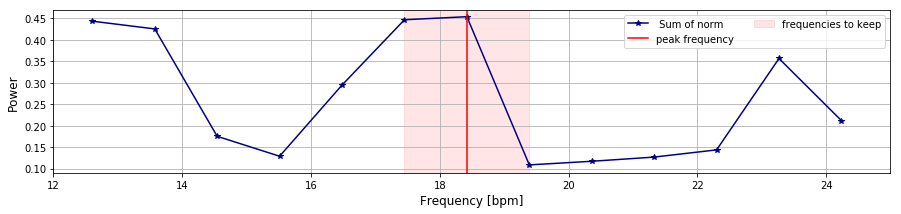

In [38]:
figb2, axb2 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 3 ) )
axb2.plot( breath_freq*60 , norm_power[breath_mask] , '-*' , label = ' Sum of norm' , color = 'navy' )
axb2.axvline( breath_peak_freq*60 , color='red' , label = 'peak frequency')
axb2.fill_betweenx( y=[ 0.09 , 0.47 ] , x1 = (breath_peak_freq-breath_err_peak_freq)*60 , 
                   x2 = (breath_peak_freq+breath_err_peak_freq)*60 , 
                   color = 'red' , alpha = 0.1 , label = 'frequencies to keep' )
axb2.set_xlim( breath_down_freq_lim*60 , breath_up_freq_lim*60 )
axb2.set_ylim( 0.09 , 0.47 )
axb2.set_xlabel( 'Frequency [bpm]' , fontsize = 12 )
axb2.set_ylabel( 'Power' , fontsize = 12 )
axb2.legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
axb2.grid()
plt.show()

## 5. **Conclusions**